In [1]:
import os
import sys
import json
from collections import Counter
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.stats import ttest_ind
import numpy as np
from numpy.linalg import norm
from numpy import sqrt
from sklearn.metrics import accuracy_score
from math import pi
import pickle
import matplotlib.pyplot as plt
from packages import data_container
from packages.data_container import Data
from packages.helper import play_trajs, rotate, sp2a, v2sp, psi, beta, d_theta, d_psi, sp2v, dist, min_dist, \
    vector_angle, signed_angle, side, inner, theta, min_sep, traj_speed
from packages.ode_simulator import ODESimulator
# For pickle to load the Data object, which is defined in packages.data_container
sys.modules['data_container'] = data_container

# file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Fajen_steer1a_data.pickle'))
# with open(file, 'rb') as f:
#     data = pickle.load(f)

# file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Bai_movObst2_data.pickle'))
# with open(file, 'rb') as f:
#     data = pickle.load(f)

file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Bai_movObst1b_data.pickle'))
with open(file, 'rb') as f:
    data = pickle.load(f)

# file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Cohen_movObst1_data.pickle'))
# with open(file, 'rb') as f:
#     data = pickle.load(f)
%matplotlib qt

In [46]:
'''Counting trials'''
cnt = 0
for i in range(len(data.trajs)):
    if i not in data.dump:
        cnt += 1
cnt

995

In [4]:
'''Animate avoidance data'''
############
subject = 3
trial = 111
############
%matplotlib qt
i = subject * 160 + trial - 1
i = 0
# p_obst = np.array(data.info['p_obst'][i])
t0 = data.info['obst_onset'][i]
p_goal = data.info['p_goal'][i]
p_subj = data.info['p_subj'][i]
p_obst = data.info['p_obst'][i]
trajs = [p_goal, p_obst, p_subj]
ws = [data.info['w_goal'], data.info['w_obst'], 0.4]
title = 'subj ' + str(data.info['subj_id'][i]) + ' trial ' + str(data.info['trial_id'][i]) + ' obst_angle: ' + str(data.info['obst_angle'][i]) + ' obst_speed: ' + str(data.info['obst_speed'][i])
print(data.info['subj_id'][i], data.info['trial_id'][i])
play_trajs(trajs, ws, data.Hz, title=title, save=False)


KeyError: 'obst_onset'

In [106]:
[(t1, i) for i, t1 in enumerate(data.info['obst_out']) if t1 and t1 < 500]

[(343, 3780), (272, 3786), (356, 3792)]

In [29]:
'''Passing distance, pass order by condition'''
%matplotlib qt
#########
# grounds = [1, 0]
# ipds = [0.07, 0]
# dsizes = [-0.1, 0, 0.1]
#########
pd1 = []
pd2 = []
po1 = []
po2 = []
dp1 = []
dp2 = []
ps1 = []
ps2 = []
for i in range(len(data.trajs)):
    if i in data.dump or data.info['obst_speed'][i] == 0:
        continue
    ground = data.info['ground'][i]
    ipd = data.info['ipd'][i]
    dsize = data.info['dsize'][i]
    t0 = data.info['obst_onset'][i]
    t1 = data.info['obst_out'][i]
    p0 = data.info['p_subj'][i][t1]
    p1 = data.info['p_obst'][i][t1]
    ps = norm(data.info['v_subj'][i][t0])
    pass_order = data.info['pass_order'][i]
    j = 0
#     for j in range(t0, t1):
#         x, y = data.info['p_subj'][i][j]
#         xo, yo = data.info['p_obst'][i][j]
#         dpsi = d_psi([x, y], [xo, yo], [vx, vy], [vxo, vyo])
#         if dpsi > 0.05:
#             break
    if pass_order == -1:
        pass_order = 0
    d = dist(p0, p1)
    if dsize == 0.1:
        pd1.append(d)
        po1.append(pass_order)
        dp1.append(j)
        ps1.append(ps)
    elif dsize == -0.1:
        pd2.append(d)
        po2.append(pass_order)
        dp2.append(j)
        ps2.append(ps)

var1, var2 = pd1, pd2
print(np.mean(var1), np.mean(var2))
print(ttest_ind(var1, var2))
plt.boxplot([var1,var2])


1.2786183648903862 0.9387687485081561
Ttest_indResult(statistic=19.68184221960851, pvalue=3.1591030313698033e-80)


{'whiskers': [<matplotlib.lines.Line2D at 0x1d7c3b24fc8>,
 'caps': [<matplotlib.lines.Line2D at 0x1d7c2902948>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d7becb4bc8>,
 'medians': [<matplotlib.lines.Line2D at 0x1d7c2902d48>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d7c2909748>,
 'means': []}

In [31]:
'''Check initial dpsi and subject passing choice, plot dpsi of matching and non-matching trials'''
subjects = set(data.info['subj_id'])
print(subjects)
sim = ODESimulator(data=data, ref=[0,1])
side_pred = []
side_true = []
dpsi_match = []
dpsi_not = []
for i in range(len(sim.data.trajs)):
    if i not in sim.data.dump and sim.data.info['obst_speed'][i] != 0:
        xg, yg, xo, yo, vxo, vyo, x, y, vx, vy, a, phi, s, dphi, ds, w0 = sim.compute_var0(i, sim.data.info['obst_onset'][i])
        # When beta and dpsi has the same sign it means pass in front, otherwise it means pass from behind
        dpsi = d_psi([x, y], [xo, yo], [vx, vy], [vxo, vyo])
        angle = sim.data.info['obst_angle'][i]
        side_pred.append(1 if angle * dpsi < 0 else -1)
        side_true.append(sim.data.info['pass_order'][i])
        if side_pred[-1] == side_true[-1]:
            dpsi_match.append(dpsi)
        else:
            dpsi_not.append(dpsi)
print('passing order matching rate ', accuracy_score(side_true, side_pred))
plt.scatter(np.random.uniform(size=len(dpsi_match)), dpsi_match, label='matching trials')
plt.scatter(np.random.uniform(size=len(dpsi_not)), dpsi_not, label='non-matching trials')
plt.ylabel('dpsi')
plt.xlabel('arbitrary')
plt.legend()



{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
Loading finished
passing order matching rate  0.7145940113299164


In [50]:
'''Match rate by threshold by condition'''
sim = ODESimulator(data=data, ref=[0,1])
thress = np.linspace(0, 0.1, 11)
match_rates = []
match_rates_ipd1 = []
match_rates_ipd0 = []
match_rates_ground1 = []
match_rates_ground0 = []
match_rates_dsize1 = []
match_rates_dsize0 = []
i_ipd1 = []
i_ipd0 = []
i_ground1 = []
i_ground0 = []
i_dsize1 = []
i_dsize0 = []
t0s = {}
for ii, thres in enumerate(thress):
    print(f'thres = {thres}')
    side_pred = []
    side_true = []
    for i in range(len(sim.data.trajs)):
        if i in sim.data.dump or sim.data.info['obst_speed'][i] == 0:
            continue
        t0 = t0s.get(i, sim.data.info['obst_onset'][i])
        t1 = sim.data.info['obst_out'][i]
        ipd = sim.data.info['ipd'][i]
        ground = sim.data.info['ground'][i]
        dsize = sim.data.info['dsize'][i]
        for j in range(t0, t1):
            xg, yg, xo, yo, vxo, vyo, x, y, vx, vy, a, phi, s, dphi, ds, w0 = sim.compute_var0(i, j)
            dpsi = d_psi([x, y], [xo, yo], [vx, vy], [vxo, vyo])
            if j == t1 - 1:
                print('reached t1 before meeting the threshold')
            if abs(dpsi) > thres:
                t0s[i] = j
                break
        angle = sim.data.info['obst_angle'][i]
        side_pred.append(1 if angle * dpsi < 0 else -1)
        side_true.append(sim.data.info['pass_order'][i])
        if ii == 0:
            i_ipd1.append(True if ipd==0.07 else False)
            i_ipd0.append(True if ipd==0 else False)
            i_ground1.append(True if ground==1 else False)
            i_ground0.append(True if ground==0 else False)
            i_dsize1.append(True if dsize==0.1 else False)
            i_dsize0.append(True if dsize==-0.1 else False)
    if ii == 0:
        i_ipd1 = np.array(i_ipd1)
        i_ipd0 = np.array(i_ipd0)
        i_ground1 = np.array(i_ground1)
        i_ground0 = np.array(i_ground0)
        i_dsize1 = np.array(i_dsize1)
        i_dsize0 = np.array(i_dsize0)
    side_pred = np.array(side_pred)
    side_true = np.array(side_true)
    match_rates.append(accuracy_score(side_true, side_pred))
    match_rates_ipd1.append(accuracy_score(side_true[i_ipd1], side_pred[i_ipd1]))
    match_rates_ipd0.append(accuracy_score(side_true[i_ipd0], side_pred[i_ipd0]))
    match_rates_ground1.append(accuracy_score(side_true[i_ground1], side_pred[i_ground1]))
    match_rates_ground0.append(accuracy_score(side_true[i_ground0], side_pred[i_ground0]))
    match_rates_dsize1.append(accuracy_score(side_true[i_dsize1], side_pred[i_dsize1]))
    match_rates_dsize0.append(accuracy_score(side_true[i_dsize0], side_pred[i_dsize0]))
    
plt.plot(thress, match_rates, label='All trials')
plt.plot(thress, match_rates_ipd1, label='disparity')
plt.plot(thress, match_rates_ipd0, label='no disparity')
plt.plot(thress, match_rates_ground1, label='ground')
plt.plot(thress, match_rates_ground0, label='no ground')
plt.plot(thress, match_rates_dsize1, label='grow')
plt.plot(thress, match_rates_dsize0, label='shrink')
plt.ylabel('Percentage')
plt.xlabel('dpsi threshold')
plt.legend()


Loading finished
thres = 0.0
thres = 0.01
thres = 0.02
thres = 0.03
thres = 0.04
thres = 0.05
thres = 0.06
thres = 0.07
thres = 0.08
thres = 0.09
thres = 0.1


In [105]:
'''Average time series of dpsi by subj and condition'''
dpsi = {}
length = 267
t = np.linspace(0, 266/90, 267)
subjs = set(data.info['subj_id'])
subjs.add(0)
for subj in subjs:
    dpsi[subj] = {}
    for ground in [1, 0]:
        dpsi[subj][ground] = {}
        for ipd in [0.07, 0]:
            dpsi[subj][ground][ipd] = {}
            for dsize in [-0.1, 0, 0.1]:
                dpsi[subj][ground][ipd][dsize] = {}
                dpsi[subj][ground][ipd][dsize]['vals'] = np.zeros(length)
                dpsi[subj][ground][ipd][dsize]['n'] = 0

for i in range(len(data.trajs)):
    if i in data.dump or data.info['obst_speed'][i] == 0:
        continue
    subj = data.info['subj_id'][i]
    ground = data.info['ground'][i]
    ipd = data.info['ipd'][i]
    dsize = data.info['dsize'][i]
    vals = np.array(abs(data.info['dpsi'][i][:length]))
    dpsi[subj][ground][ipd][dsize]['vals'] += vals
    dpsi[subj][ground][ipd][dsize]['n'] += 1
    dpsi[0][ground][ipd][dsize]['vals'] += vals
    dpsi[0][ground][ipd][dsize]['n'] += 1

plt.plot()
ground_con = {1:'ground', 0:'no ground'}
ipd_con = {0.07:'disparity', 0:'no disparity'}
dsize_con = {0.1:'grow', -0.1:'shrink', 0:'constant'}
for ground in [1, 0]:
    for ipd in [0.07, 0]:
        for dsize in [-0.1, 0, 0.1]:
            plt.plot(t, dpsi[0][ground][ipd][dsize]['vals'] / dpsi[0][ground][ipd][dsize]['n'], 
                     label=f'{ground_con[ground]}, {ipd_con[ipd]}, {dsize_con[dsize]}')
plt.legend()


In [93]:
'''Plot average time series by subject'''
length = 267
subjs = {}
t = np.linspace(0, 266/90, 267)
for subj in set(data.info['subj_id']):
    n = 0
    vals = np.zeros(length)
    for i in range(len(data.trajs)):
        if i in data.dump or data.info['obst_speed'][i] == 0:
            continue
        subj_id = data.info['subj_id'][i]
        ground = data.info['ground'][i]
        ipd = data.info['ipd'][i]
        dsize = data.info['dsize'][i]
        dpsi = abs(data.info['dpsi'][i][:length])
        if subj_id == subj:
            n += 1
            vals += np.array(dpsi)
    vals /= n
    plt.plot(t, vals, label='subj ' + str(subj))
plt.xlabel('time (s)')
plt.ylabel('dpsi (rad/s)')
plt.legend()

In [115]:
'''Plot average time series by one condition'''
length = 267
n = 0
vals = np.zeros(length)
t = np.linspace(0, 266/90, 267)
for i in range(len(data.trajs)):
    if i in data.dump or data.info['obst_speed'][i] == 0:
        continue
    subj_id = data.info['subj_id'][i]
    ground = data.info['ground'][i]
    ipd = data.info['ipd'][i]
    dsize = data.info['dsize'][i]
    dpsi = abs(data.info['dpsi'][i][:length])
    if dsize == 0:
        n += 1
        vals += np.array(dpsi)
vals /= n
plt.plot(t, vals, label='constant size')
plt.xlabel('time (s)')
plt.ylabel('dpsi (rad/s)')
plt.legend()

In [80]:
data.info['dpsi'][2]

array([0.01792718, 0.01803001, 0.01813575, 0.01824427, 0.01835546,
       0.01846918, 0.0185853 , 0.01870369, 0.01882419, 0.01894665,
       0.01907091, 0.01919683, 0.01932422, 0.01945294, 0.0195828 ,
       0.01971364, 0.01984527, 0.01997753, 0.02011024, 0.02024322,
       0.02037629, 0.02050927, 0.02064199, 0.02077427, 0.02090593,
       0.0210368 , 0.02116672, 0.02129551, 0.021423  , 0.02154905,
       0.02167348, 0.02179615, 0.02191692, 0.02203563, 0.02215215,
       0.02226635, 0.0223781 , 0.02248729, 0.02259381, 0.02269754,
       0.0227984 , 0.02289629, 0.02299114, 0.02308286, 0.0231714 ,
       0.0232567 , 0.02333871, 0.02341739, 0.02349272, 0.02356467,
       0.02363323, 0.0236984 , 0.02376019, 0.02381861, 0.02387369,
       0.02392547, 0.02397399, 0.0240193 , 0.02406148, 0.02410058,
       0.02413671, 0.02416993, 0.02420036, 0.02422811, 0.02425328,
       0.02427601, 0.02429643, 0.02431467, 0.02433089, 0.02434524,
       0.02435788, 0.02436898, 0.02437871, 0.02438726, 0.02439

In [62]:
'''Find the min length of simulation window'''
min_t = float('inf')
for i in range(len(data.trajs)):
    if i in data.dump or data.info['obst_speed'][i] == 0:
        continue
    dpsi = data.info['dpsi'][i]
    min_t = min(min_t, len(dpsi))
min_t

267

In [31]:
'''Count pass order by condition'''
#########
angle = 157.5
speed = 1.1
#########
fpass = 0
total = 0
for i in range(len(data.trajs)):
    if abs(data.info['obst_angle'][i]) != angle or data.info['obst_speed'][i] != speed:
        continue
    if data.info['pass_order'][i] == 1:
        fpass += 1
    total += 1
print(fpass, total)
print(fpass / total)

27 66
0.4090909090909091


In [ ]:
'''Minimum Passing Distance'''
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title('Signed predicted minimum passing distance (SMPD)')
ax.set_ylabel('SMPD (m)')
ax.set_xlabel('normalized time (%)')
ax.set_ylim((-2, 2))
for i in range(len(data.trajs)):
    t0 = data.info['stimuli_onset'][i]
    t1 = data.info['stimuli_out'][i]
    p0 = data.info['p_subj'][i][t0:t1]
    p1 = data.info['p_obst'][i][t0:t1]
    v0 = data.info['v_subj'][i][t0:t1]
    v1 = data.info['v_obst'][i][t0:t1]
    t = np.linspace(0, 100, len(p0))
    smpd = []
    for _p0, _p1, _v0, _v1 in zip(p0, p1, v0, v1):        
        smpd.append(min_sep(_p0, _p1, _v0, _v1)[0])
    ax.plot(t, smpd, 'k', linewidth=0.1, alpha=0.5)
    
    

In [ ]:
'''Plot acceleration angle and magnitude'''
%matplotlib qt
trials = range(400,401)
subject = 1
con_angle = [90, -90]
con_speed = []
fig0 = plt.figure()
ax0 = fig0.add_subplot()
fig1 = plt.figure()
ax1 = fig1.add_subplot()
for i in trials:
    angle = data.info['obst_angle'][i]
    speed = data.info['obst_speed'][i]
    subj_id = data.info['subj_id'][i]
    if i in data.dump:
        continue
#     if angle not in con_angle or subj_id != subject:
#         continue
    t0, t1 = data.info['stimuli_onset'][i], data.info['stimuli_out'][i]
    p0, p1, a0 = np.array(data.info['p_subj'][i][t0:t1]), np.array(data.info['p_obst'][i][t0:t1]), np.array(data.info['a_subj'][i][t0:t1])
    angles = signed_angle(p1 - p0, a0)
    ax0.scatter(range(len(angles)), angles, s=1)
    ax1.plot(norm(a0, axis=-1))
    print(data.info['subj_id'][i], data.info['trial_id'][i])

In [ ]:
'''Plot dpsi dtheta by time'''
%matplotlib qt
subjects = range(16)
n = len(data.trajs)
fig0 = plt.figure()
ax0 = fig0.add_subplot()
fig1 = plt.figure()
ax1 = fig1.add_subplot()
fig2 = plt.figure()
ax2 = fig2.add_subplot()
for i in range(2,3):
    if (data.info['subj_id'][i] in subjects and
        i not in data.dump and
        data.info['obst_speed'][i] != 0 and
        abs(data.info['obst_angle'][i]) != 180):
        t0, t1 = data.info['stimuli_onset'][i], data.info['stimuli_out'][i]
        p0, p1 = np.array(data.info['p_subj'][i][t0:t1]), np.array(data.info['p_obst'][i][t0:t1])
        v0, v1 = np.array(data.info['v_subj'][i][t0:t1]), np.array(data.info['v_obst'][i])
        a0 = np.array(data.info['a_subj'][i][t0:t1])
        a0 = norm(a0, axis=-1)
        v1 = np.tile(v1, (len(v0), 1))
        dpsis = np.absolute(d_psi(p0, p1, v0, v1))
        dthetas = d_theta(p0, p1, v0, v1, w=0.1)
        thetas = theta(p0, p1, w=0.1)
        ratio = dthetas/thetas
        ax0.plot(a0)
        c1, c2 = 0, 0.2
        ax1.plot((ratio+c1)/(dpsis+c2))
        ax2.scatter(ratio[60:80], a0[60:80], s=1)
#         ax2.scatter(range(len(dpsis)), dthetas/dpsis, s=1)

In [71]:
'''Plot data by condition'''
#####################
subject = 3
con_ang = [112.5]
con_spd = [1.1]
con_ipd = [0, 0.07]
# con_ang = set(data.info['obst_angle'])
# con_spd = set(data.info['obst_speed'])
#####################
%matplotlib qt
plt.figure()
n = 0
for i in range(len(data.trajs)):
    obst_speed = data.info['obst_speed'][i]
    obst_angle = data.info['obst_angle'][i]
    ipd = data.info['ipd'][i]
    subj_id = data.info['subj_id'][i]
    if subject != -1 and subj_id != subject:
        continue
    if not (obst_speed in con_spd and abs(obst_angle) in con_ang and ipd in con_ipd):
        continue
    subj = data.info['p_subj'][i]
    obst = np.array(data.info['p_obst'][i])
    n += 1
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) + pi / 2)
    if obst_angle < 0:
        subj[:, 0] *= -1
        obst[:, 0] *= -1
    if ipd == 0:
        plt.plot(subj[:, 0], subj[:, 1], color='r')
    else:
        plt.plot(subj[:, 0], subj[:, 1], color='b')
    plt.plot(obst[:, 0], obst[:, 1])
ax = plt.gca()
# ax.set_aspect('equal')
ax.set_title('subj ' + str(subject) + ' angle: ' + str(con_ang[0]) + ' speed: ' + str(con_spd[0]))
print(n)

72


In [44]:
'''Plot data by subject'''
#####################
subject = 13
#####################
%matplotlib qt
fig = plt.figure()
fig.suptitle('Subject ' + str(subject))
axes = {}
obst_angle = [90, 112.5, 135, 157.5, 180]
obst_speed = [0.9, 1.0, 1.1, 1.2, 1.3]
i_plot = 1
for angle in obst_angle:
    for speed in obst_speed:
        axes[(angle, speed)] = fig.add_subplot(5, 5, i_plot)
        axes[(angle, speed)].set_xlim(-3, 3)
        axes[(angle, speed)].set_ylim(-7, 5)
        axes[(angle, speed)].set_title(str(angle) + '° ' + str(speed) + 'm/s')
        axes[(angle, speed)].set_aspect('equal')
        i_plot += 1
for i in range(len(data.trajs)):
    speed = data.info['obst_speed'][i]
    angle = data.info['obst_angle'][i]
    subj_id = data.info['subj_id'][i]
    if subj_id != subject or speed == 0:
        continue
    subj = np.array(data.info['p_subj'][i])
    obst = np.array(data.info['p_obst'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) + pi / 2)
    if angle < 0:
        subj[:, 0] *= -1
        obst[:, 0] *= -1
    axes[(abs(angle), speed)].plot(subj[:, 0], subj[:, 1])
    axes[(abs(angle), speed)].plot(obst[:, 0], obst[:, 1])

In [ ]:
'''Check trial length from match_onset to stimuli_out'''
match_onsets = []
lens = []
for i in range(len(data.trajs)):
    if i not in data.dump:
        p0 = data.info['p_subj'][i]
        p1 = data.info['p_obst'][i]
        v0 = data.info['v_subj'][i]
        v1 = data.info['v_obst'][i]
        stimuli_out = data.info['stimuli_out'][i]
        stimuli_onset = data.info['stimuli_onset'][i]
        match_onset = data.info['match_onset'][i]
        dpsis = d_psi(p0, p1, v0, v1)
        if stimuli_out - match_onset <= 30:
            plt.plot(dpsis)
            plt.plot(dpsis[match_onset:stimuli_out])
            print(i)
        match_onsets.append(data.info['match_onset'][i])
        lens.append(data.info['stimuli_out'][i] - data.info['match_onset'][i])
# plt.hist(match_onsets)
# plt.figure()
# plt.hist(lens)

### Approach data

In [37]:
'''Animate approach data'''
i = 528
t0 = data.info['stimuli_onset'][i]
t1 = data.info['stimuli_out'][i]
print(t0, t1)
p_goal = data.info['p_goal'][i][t0:t1]
p_subj = data.info['p_subj'][i][t0:t1]
trajs = [p_goal, p_subj]
ws = [data.info['w_goal'], 0.4]
title = 'subj ' + str(data.info['subj_id'][i]) + ' trial ' + str(data.info['trial_id'][i]) + ' goal_d0: ' + str(data.info['goal_d0'][i]) + ' goal_angle: ' + str(data.info['goal_angle'][i]) + ' leader_s0: ' + str(data.info['leader_s0'][i])
print(data.info['subj_id'][i], data.info['trial_id'][i])
play_trajs(trajs, ws, data.Hz, title=title, save=False)

None None
4 9


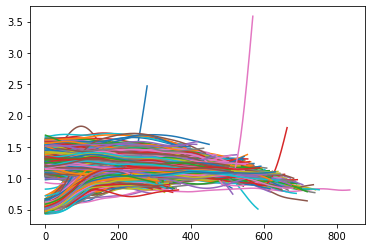

In [3]:
'''Plot speed'''
for i in range(len(data.trajs)):
    if data.info['stimuli_out'][i] and data.info['stimuli_onset'][i] and data.info['leader_s0'] and i not in data.dump:
        t0, t1 = data.info['stimuli_onset'][i], data.info['stimuli_out'][i]
        v_subj = data.info['v_subj'][i]
        s_subj = norm(v_subj, axis=1)
        plt.plot(s_subj[t0:t1])

In [4]:
'''Check trial length'''
%matplotlib qt
a = []
for i in range(len(data.trajs)):
    if data.info['stimuli_out'][i] and data.info['stimuli_onset'][i] and data.info['leader_s0'] and i not in data.dump:
        l = data.info['stimuli_out'][i] - data.info['stimuli_onset'][i]
        a.append(l)
        if (l < 100 or l > 1000) and i not in data.dump:
            print(i, l)
plt.plot(a)

2 70
4 73
9 86
11 70
14 87
15 88
17 70
19 97
20 91
21 71
22 72
24 89
25 87
26 70
28 74
31 68
32 67
33 71
34 92
35 71
40 71
41 70
42 71
43 70
46 88
49 90
50 88
51 92
52 86
54 86
57 71
58 92
60 70
65 87
66 72
69 69
71 92
72 67
75 89
78 87
87 71
88 85
89 69
92 86
95 85
96 69
97 69
99 89
101 69
104 87
107 87
108 87
110 91
111 87
113 85
114 71
115 69
116 86
118 70
122 68
131 64
134 82
136 69
137 69
139 70
141 93
142 77
143 82
144 88
146 68
147 90
149 72
150 75
153 69
164 87
165 86
169 89
171 90
172 68
176 84
178 87
179 67
180 66
181 66
183 62
184 88
187 70
190 87
192 68
193 84
195 87
197 89
198 66
204 82
207 61
208 66
209 89
212 67
215 88
217 87
219 85
222 64
224 83
227 63
229 86
231 74
232 86
233 82
236 60
237 61
242 85
243 65
245 90
246 63
248 84
251 67
252 64
253 84
254 65
257 66
260 69
263 74
268 72
269 63
275 69
276 72
278 94
279 94
283 90
286 68
287 70
290 94
292 86
295 90
300 89
302 94
303 95
304 96
305 72
307 96
308 97
309 74
311 67
314 94
315 69
316 71
322 68
324 70
325 94
330 71
3

In [57]:
'''Check trajectories'''
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['leader_s0']:
        if data.info['goal_d0'][i] == 8:
            plt.plot(data.info['p_subj'][i][:, 0], data.info['p_subj'][i][:, 1])

In [54]:
set(data.info['goal_d0'])

{0.0, 4.0, 8.0}

In [ ]:

'''Plot data by condition'''
#####################
subject = 0
s0 = [1.4]
d0 = [8]
angle = [15]
s0 = set(data2.info['goal_s0'])
d0 = set(data2.info['goal_d0'])
angle = set(data2.info['goal_angle'])
#####################
%matplotlib qt
plt.figure()
for i in range(len(data2.trajs)):
    goal_s0 = data2.info['goal_s0'][i]
    goal_d0 = data2.info['goal_d0'][i]
    goal_angle = data2.info['goal_angle'][i]
    subj_id = data2.info['subj_id'][i]
    if subj_id != subject:
        continue
    if not (goal_s0 in s0 and goal_d0 in d0 and abs(goal_angle) in angle):
        continue
    subj = np.array(data2.info['p_subj'][i])
    goal = np.array(data2.info['p_goal'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        goal = rotate(goal, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        goal = rotate(goal, np.arctan(11 / 9) + pi / 2)
#     if goal_angle < 0:
#         subj[:, 0] *= -1
#         goal[:, 0] *= -1
    plt.plot(subj[:, 0], subj[:, 1])
    print(subj)
    plt.plot(goal[:, 0], goal[:, 1])
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title(f'subj {str(subject)} angle: {str(angle)} s0: {str(s0)} d0: {str(d0)}')

In [ ]:
'''Cohen experiments'''
file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Cohen_movObst_exp1_data.pickle'))
with open(file, 'rb') as f:
    cohen1 = pickle.load(f)

In [ ]:
cohen1.info['pass_order']
# data.info['pass_order']

In [9]:
''' Check optimal parameters from training results '''
bests = {} 
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Results', 'Bai_movObst1b_all_fajen_approach1&2'))
filenames = [os.path.join(path, name) for name in os.listdir(path) if name[-3:] == 'txt']
filenames = [filenames[2]]
# b1s = []
# k1s = []
errs = []
for filename in filenames:
    with open(filename, 'rb') as f:
        best = 0
        e_min = float('inf')
        for i, line in enumerate(f):
            if i == 1:
                subj_id = line[-5:-2]
            if i >= 11:
                try:
                    err = str(line).split("\\t")[-4][:10]
                    if err[0] == '0':
                        err = float(err)
                        if err < e_min:
                            e_min = err
                            best = str(line).replace("\\", "")
                except:
                    pass
                # Find all parameters that have small error
#                 if subj_id == 0 and float(err) < 0.16:
#                     model = str(line).split("\\t")[1].split("}")[1][1:] + '}'
#                     model = model.replace('\'', '\"')
#                     d = json.loads(model)
#                     b1s.append(d['b1'])
#                     k1s.append(d['k1'])
#                     errs.append(float(err))
    bests[subj_id] = best
for i, best in bests.items():
    print('\n')
    print(i, best)



b'all' b"4269t[{'name': 'fajen_approach2', 'b1': 3.7380520763369196, 'k1': 2.87947916970264, 'c1': 0.2206162881805807, 'c2': 0.960123052819782, 'b2': 2.359847074014972, 'k2': 2.570997808604569, 'ps': 1.174382457526894}]t0.10255794870636022torder_accuracytNonet0:00:25rn"


In [22]:
''' Check optimal parameters from cross validation'''
bests = {} 
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Results', 'Bai_movObst1b_individual_fajen_approach1&2', 'fajen_approach2'))
filenames = [os.path.join(path, name) for name in os.listdir(path) if name[-3:] == 'txt']
errs = []
for filename in filenames:
    with open(filename, 'rb') as f:
        best = 0
        e_min = float('inf')
        if filename[-6] == '_':
            subj_id = int(filename[-5])
        else:
            subj_id = int(filename[-6:-4])
        for i, line in enumerate(f):
            if i > 10:
                try:
                    err = str(line).split("\\t")[2]
                    if err[0] == '0':
                        err = float(err)
                        if err < e_min:
                            e_min = err
                            best = str(line).replace("\\", "")
                except:
                    pass

    bests[subj_id] = best
for i, err in bests.items():
    print('\n')
    print(i, err)



10 b"5780t[{'name': 'fajen_approach2', 'b1': 4.294586773127741, 'k1': 10.940580271301643, 'c1': 0.7249070798631742, 'c2': 0.230122685199928, 'b2': 3.129184115912155, 'k2': 2.662932210845456, 'ps': 0.982896408182306}]t0.11376770224746184torder_accuracytNonet0:00:02rn"


11 b"4841t[{'name': 'fajen_approach2', 'b1': 2.6686147220499743, 'k1': 5.738830402782805, 'c1': 0.778277559046697, 'c2': 0.4992475894022052, 'b2': 3.3906476034125292, 'k2': 2.8279395254386674, 'ps': 1.2842441330817338}]t0.10675144637669298torder_accuracytNonet0:00:01rn"


12 b"3601t[{'name': 'fajen_approach2', 'b1': 7.7855258192068435, 'k1': 4.068891048830318, 'c1': 0.3066495719696504, 'c2': 1.2196321300214885, 'b2': 2.70757462588659, 'k2': 3.0054711131627405, 'ps': 1.1087062197053004}]t0.11687719351687352torder_accuracytNonet0:00:03rn"


13 b"4439t[{'name': 'fajen_approach2', 'b1': 4.075907968599436, 'k1': 9.243017312440472, 'c1': 0.5831183555340775, 'c2': 0.36162337833154756, 'b2': 2.329812666404041, 'k2': 2.34773270

In [ ]:
bests